### EDA on Evidence Objects (from ES)

In [61]:
import glob
import os.path as osp
import tqdm
import json
import pandas as pd
import numpy as np
import dask
import dask.dataframe as dd
import matplotlib.pyplot as plt
import plotnine as pn
data_file = '/lab/data/raw/evidence-data-stage-2.parquet'
sample_file = '/lab/data/raw/evidence-data-stage-2.sample.csv'

In [30]:
dask.config.set(scheduler='synchronous') # threads, processes, or synchronous
# dask.config.set(scheduler='processes') # activate when ready (i.e. more RAM)

## Export Sample 

In [3]:
# Load individual records from ES export
df = dd.read_parquet(data_file)

In [4]:
df

,access_level,disease,drug,evidence,id,literature,private,scores,sourceID,target,type,unique_association_fields,validated_against_schema_version,batch
npartitions=163,,,,,,,,,,,,,,
,object,object,object,object,object,object,object,object,object,object,object,object,object,category[known]
,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
# Downsample to size large enough for laptop but
# continue analysis with out-of-core assumption
df = df.sample(frac=.05).compute()
df.info()

In [38]:
# Drop even this tiny sample into some file to be loaded without
# using the same kernel as pyarrow as it has ridiculous memory leaks
df.to_csv(sample_file, index=False)
sample_file

## Initialize Data Source

In [4]:
# df = dd.read_parquet('/lab/data/raw/evidence-data-stage-2.parquet')
df = pd.read_csv(sample_file)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81327 entries, 0 to 81326
Data columns (total 14 columns):
access_level                        81327 non-null object
disease                             81327 non-null object
drug                                19144 non-null object
evidence                            81327 non-null object
id                                  81327 non-null object
literature                          22247 non-null object
private                             81327 non-null object
scores                              81327 non-null object
sourceID                            81327 non-null object
target                              81327 non-null object
type                                81327 non-null object
unique_association_fields           81327 non-null object
validated_against_schema_version    71105 non-null object
batch                               81327 non-null int64
dtypes: int64(1), object(13)
memory usage: 8.7+ MB


In [5]:
df = dd.from_pandas(df, npartitions=1) 

In [6]:
df

,access_level,disease,drug,evidence,id,literature,private,scores,sourceID,target,type,unique_association_fields,validated_against_schema_version,batch
npartitions=1,,,,,,,,,,,,,,
0,object,object,object,object,object,object,object,object,object,object,object,object,object,int64
81326,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Stats

In [7]:
len(df)

81327

In [8]:
df['sourceID'].value_counts().compute()

phenodigm             25010
chembl                19144
expression_atlas      10222
gwas_catalog           9080
eva                    4839
slapenrich             3688
cancer_gene_census     3017
phewas_catalog         2827
uniprot                1549
reactome                518
genomics_england        511
eva_somatic             373
uniprot_literature      229
intogen                 109
gene2phenotype           84
crispr                   81
sysbio                   22
uniprot_somatic          14
progeny                  10
Name: sourceID, dtype: int64

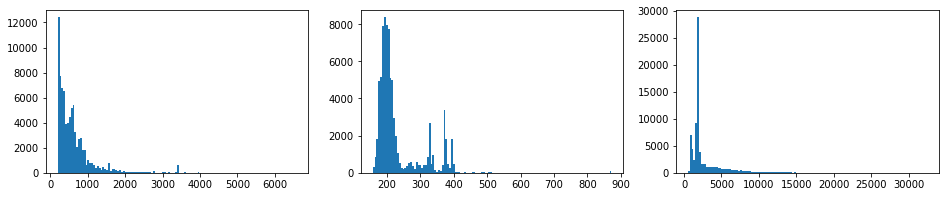

In [9]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(16, 3)
ax[0].hist(df['disease'].str.len().compute(), bins=128)
ax[1].hist(df['target'].str.len().compute(), bins=128)
ax[2].hist(df['evidence'].str.len().compute(), bins=128)
None

### Disease

In [17]:
# Example record
print(json.dumps(json.loads(df['disease'].head(1).iloc[0]), indent=2))

{
  "efo_info": {
    "efo_id": "http://www.orpha.net/ORDO/Orphanet_289902",
    "label": "3-methylglutaconic aciduria",
    "path": [
      [
        "EFO_0000408",
        "EFO_0000589",
        "Orphanet_68367",
        "Orphanet_79062",
        "Orphanet_289899",
        "Orphanet_79163",
        "Orphanet_289902"
      ],
      [
        "EFO_0000408",
        "EFO_0000508",
        "Orphanet_68367",
        "Orphanet_79062",
        "Orphanet_289899",
        "Orphanet_79163",
        "Orphanet_289902"
      ]
    ],
    "therapeutic_area": {
      "codes": [],
      "labels": []
    }
  },
  "id": "Orphanet_289902",
  "name": "3-methylglutaconic aciduria",
  "source_name": "3-Methylglutaconic Aciduria With Cataracts, Neurologic Involvement, And Neutropenia"
}


In [31]:
def from_json(v):
    try:
        return json.loads(v)
    except:
        return None

In [12]:
def get_labels(v):
    v = from_json(v)
    if v is None:
        return ''
    if 'efo_info' in v and 'therapeutic_area' in v['efo_info']:
        return ':'.join(sorted(v['efo_info']['therapeutic_area']['labels']))
    return 'NA'
df['disease'].apply(get_labels, meta='foo').value_counts().compute()

    81327
dtype: int64

In [15]:
def get_path_len(v):
    v = from_json(v)
    if v is None:
        return np.nan
    if 'efo_info' in v and 'path' in v['efo_info']:
        return max([len(p) for p in v['efo_info']['path']])
    return np.nan
df['disease'].apply(get_path_len, meta=1).value_counts().compute().sort_index()

1         1
2      1549
3      6629
4     12241
5     15224
6     14783
7     11700
8      8675
9      8036
10     1322
11      901
12      231
13       35
dtype: int64

### Evidence

In [62]:
# Example record
print(json.dumps(json.loads(df['evidence'].head(1).iloc[0]), indent=2))

{
  "biological_model": {
    "allele_ids": "",
    "allelic_composition": "Usp32<em1(IMPC)Mhzh>",
    "date_asserted": "2019-08-21T08:56:05.758262",
    "evidence_codes": [
      "http://identifiers.org/eco/ECO:0000179"
    ],
    "genetic_background": "C57BL/6N",
    "is_associated": false,
    "model_gene_id": "http://identifiers.org/ensembl/ENSMUSG00000000804",
    "model_id": "NULL-19D18244C#het",
    "phenotypes": [
      {
        "id": "MP:0000222",
        "label": "decreased neutrophil cell number",
        "species": "mouse",
        "term_id": "http://purl.obolibrary.org/obo/MP_0000222"
      },
      {
        "id": "MP:0005419",
        "label": "decreased circulating serum albumin level",
        "species": "mouse",
        "term_id": "http://purl.obolibrary.org/obo/MP_0005419"
      },
      {
        "id": "MP:0011967",
        "label": "increased or absent threshold for auditory brainstem response",
        "species": "mouse",
        "term_id": "http://purl.obolibrar

In [35]:
# Get unique sets of keys at top level of evidence object
def get_evidence_keys(v):
    ev = from_json(v)
    if ev is None:
        return ''
    return ':'.join(sorted(list(ev.keys())))
df['evidence'].apply(get_evidence_keys, meta=str).value_counts().compute()

biological_model:disease_model_association:evidence_codes:evidence_codes_info:orthologs                                                                                                                                                                                                     25010
drug2clinic:evidence_codes:evidence_codes_info:target2drug                                                                                                                                                                                                                                  19144
evidence_codes:evidence_codes_info:gene2variant:variant2disease                                                                                                                                                                                                                             18295
comparison_name:confidence_level:date_asserted:evidence_codes:evidence_codes_info:experiment_overview:is_associated:log2_fold_chan

In [58]:
# Fetch resource scores (i.e. evidence string scores) by source and type
# noting that there may be multiple for a single evidence record
def get_resource_scores(r):
    src = r['sourceID']
    ev = to_json(r['evidence'])
    if ev is None:
        return pd.DataFrame({'src': [src]}).assign(key=None, score=None, type=None)
    df = []
    for k in ev.keys():
        if isinstance(ev[k], dict) and 'resource_score' in ev[k]:
            score = ev[k]['resource_score']
            df.append({'key': k, 'score': score['value'], 'type': score['type']})
    return pd.DataFrame(df).assign(src=src)

def get_resource_scores_df(df):
    return pd.concat([get_resource_scores(r) for _, r in df.iterrows()], sort=True)

res = df.map_partitions(get_resource_scores_df).compute()
res.head()

,key,score,src,type
0,biological_model,1.0000,phenodigm,probability
1,disease_model_association,1.0000,phenodigm,summed_total
2,orthologs,1.0000,phenodigm,probability
0,biological_model,1.0000,phenodigm,probability
1,disease_model_association,0.9448,phenodigm,summed_total


In [60]:
res.groupby(['src', 'key', 'type']).size()

src             key                        type        
chembl          drug2clinic                probability     19144
                target2drug                probability     19144
eva             gene2variant               probability      4839
                variant2disease            pvalue           4839
gwas_catalog    gene2variant               probability      9080
                variant2disease            pvalue           9080
phenodigm       biological_model           probability     25010
                disease_model_association  summed_total    25010
                orthologs                  probability     25010
phewas_catalog  gene2variant               probability      2827
                variant2disease            pvalue           2827
uniprot         gene2variant               probability      1549
                variant2disease            probability      1549
dtype: int64

In [70]:
# Show score summaries
res.groupby(['src', 'key', 'type'])['score'].describe().round(2)

count  mean   std  \
src            key                       type                                
chembl         drug2clinic               probability   19144.0  0.50  0.38   
               target2drug               probability   19144.0  1.00  0.00   
eva            gene2variant              probability    4839.0  0.85  0.12   
               variant2disease           pvalue         4839.0  0.00  0.00   
gwas_catalog   gene2variant              probability    9080.0  0.60  0.08   
               variant2disease           pvalue         9080.0  0.00  0.00   
phenodigm      biological_model          probability   25010.0  1.00  0.00   
               disease_model_association summed_total  25010.0  0.96  0.04   
               orthologs                 probability   25010.0  1.00  0.00   
phewas_catalog gene2variant              probability    2827.0  0.50  0.00   
               variant2disease           pvalue         2827.0  0.02  0.01   
uniprot        gene2variant              probability    1549.0  0.70  0.00   
               variant2disease           probability    1549.0  1.00  0.04   

                                                        min   25%   50%   75%  \
src            key                       type                                   
chembl         drug2clinic               probability   0.09  0.20  0.20  1.00   
               target2drug               probability   1.00  1.00  1.00  1.00   
eva            gene2variant              probability   0.50  0.70  0.95  0.95   
               variant2disease           pvalue        0.00  0.00  0.00  0.00   
gwas_catalog   gene2variant              probability   0.50  0.50  0.65  0.65   
               variant2disease           pvalue        0.00  0.00  0.00  0.00   
phenodigm      biological_model          probability   1.00  1.00  1.00  1.00   
               disease_model_association summed_total  0.90  0.93  0.96  1.00   
               orthologs                 probability   1.00  1.00  1.00  1.00   
phewas_catalog gene2variant              probability   0.50  0.50  0.50  0.50   
               variant2disease           pvalue        0.00  0.01  0.02  0.04   
uniprot        gene2variant              probability   0.70  0.70  0.70  0.70   
               variant2disease           probability   0.50  1.00  1.00  1.00   

                                                        max  
src            key                       type                
chembl         drug2clinic               probability   1.00  
               target2drug               probability   1.00  
eva            gene2variant              probability   1.00  
               variant2disease           pvalue        0.00  
gwas_catalog   gene2variant              probability   0.95  
               variant2disease           pvalue        0.00  
phenodigm      biological_model          probability   1.00  
               disease_model_association summed_total  1.00  
               orthologs                 probability   1.00  
phewas_catalog gene2variant              probability   0.50  
               variant2disease           pvalue        0.05  
uniprot        gene2variant              probability   0.70  
               variant2disease           probability   1.00

/usr/local/lib/python3.7/site-packages/mizani/bounds.py:443: RuntimeWarning: overflow encountered in double_scalars
  return np.abs((x[0] - x[1]) / m) < tol


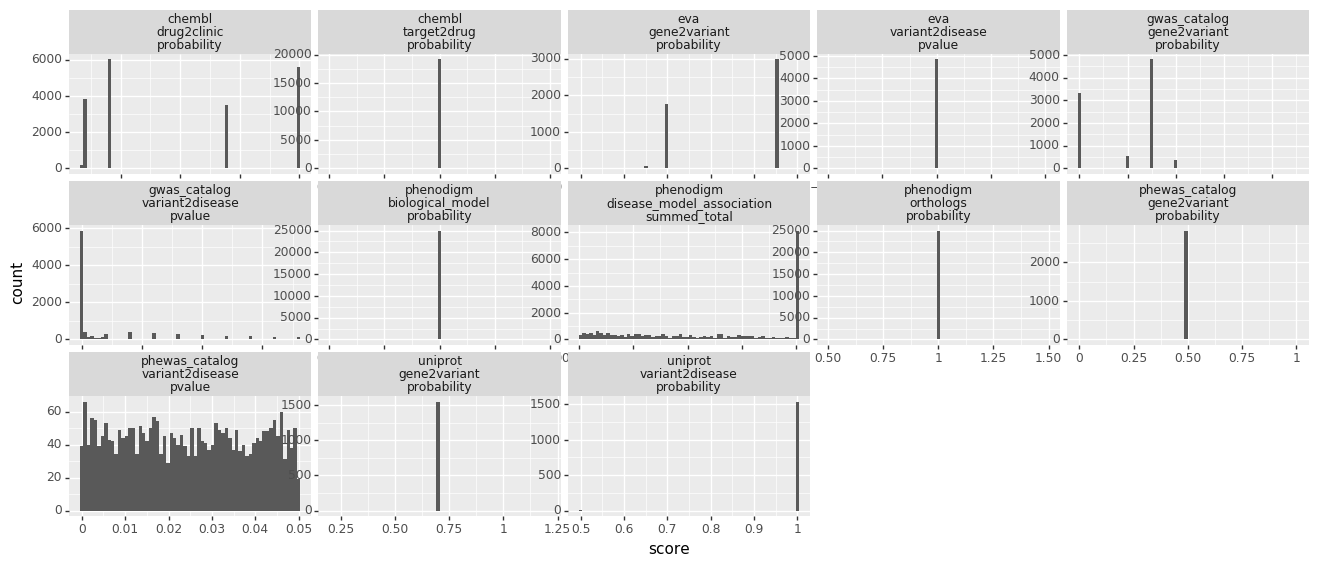

<ggplot: (8789023535769)>

In [68]:
# Show resource scores by source and score type to see how often they are simply mapped 
# from categorical values (which should be obvious with low cardinality histograms)
(
    pn.ggplot(res, pn.aes(x='score')) + 
    pn.facet_wrap('~src + key + type', scales='free', ncol=5) + 
    pn.geom_histogram(bins=64) +
    pn.theme(figure_size=(16,6))
)